In [1]:
"""
Variational Autoencoder with a STN and Modified Loss function and inverse STN and compare reconstruction loss
Removed the classification part 
This is a MNIST classifier 

Encoder(Localizaton network) -> CNN to predict affine transformation matrix
STN -> Apply affine transformation
Decoder -> CNN to classify transformed images from STN


"""

'\nVariational Autoencoder with a STN and Modified Loss function and inverse STN and compare reconstruction loss\nRemoved the classification part \nThis is a MNIST classifier \n\nEncoder(Localizaton network) -> CNN to predict affine transformation matrix\nSTN -> Apply affine transformation\nDecoder -> CNN to classify transformed images from STN\n\n\n'

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras import Model
import numpy as np
from utils.data_manager import ClutteredMNIST
from utils.visualizer import plot_mnist_sample
from utils.visualizer import print_evaluation
from utils.visualizer import plot_mnist_grid
from components.STN import BilinearInterpolation

## Dataset creation

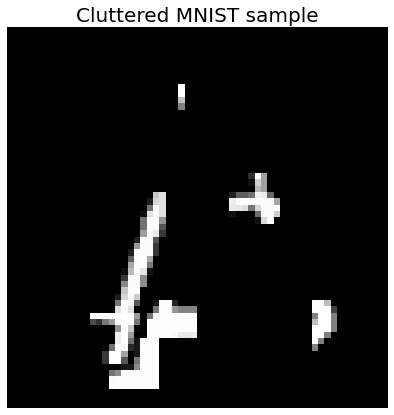

In [3]:
dataset_path = "./datasets/mnist_cluttered_60x60_6distortions.npz"
batch_size = 256
num_epochs = 30

data_manager = ClutteredMNIST(dataset_path)
train_data, val_data, test_data = data_manager.load()
x_train, y_train = train_data
plot_mnist_sample(x_train[7])

## Sampling layer

In [4]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder layer

In [5]:
class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=3,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.conv_1 = layers.Conv2D(20, (5, 5), padding='same', activation='relu')
    self.max_1 = layers.MaxPool2D(pool_size=(2, 2))
    self.conv_2 = layers.Conv2D(20, (5, 5), activation='relu')
    self.max_2 = layers.MaxPool2D(pool_size=(2, 2))
    
    self.flatten = layers.Flatten()
    
    self.dense_1 = layers.Dense(50, activation='relu')
    
    self.dense_mean = layers.Dense(3)
    self.dense_log_var = layers.Dense(3)
    
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.max_1(x)
    x = self.conv_2(x)
    x = self.max_2(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


## Decoder layer

In [6]:
class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               num_classes,
               intermediate_dim=64,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.conv_1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
    self.max_1 = layers.MaxPool2D(pool_size=(2, 2))
    self.conv_2 = layers.Conv2D(32, (3, 3), activation='relu')
    self.max_2 = layers.MaxPool2D(pool_size=(2, 2))
    self.flatten = layers.Flatten()
    self.dense_1 = layers.Dense(256, activation='relu')
#     self.dense_output = layers.Dense(num_classes, activation='softmax')
    self.dense_output = layers.Dense(num_classes)

    
  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.max_1(x)
    x = self.conv_2(x)
    x = self.max_2(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dense_output(x)
    return x


## Variational Auto Encoder

In [7]:
a = tf.ones((10,3))

In [8]:
b = tf.ones(a.shape)

In [9]:
class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               num_classes,
               intermediate_dim=64,
               latent_dim=3,
               name='autoencoder',
               **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.num_classes = num_classes
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.stn = BilinearInterpolation((30, 30), name='stn_layer')
    self.re_stn = BilinearInterpolation((60, 60), name='stn_layer')

  def call(self, inputs):
    z_mean, z_log_var, z_where = self.encoder(inputs)
    n = z_where.shape[0]
    
    z_where_indexes = tf.repeat([[0,0,1,0,0,2]], n, axis=0)
    z_where_selections = tf.repeat([[1.0, 0.0 , 1.0, 0.0, 1.0, 1.0]], n, axis=0)
    z_where_modified = tf.gather(z_where, z_where_indexes, batch_dims=1)
    z_where_modified = tf.math.multiply(z_where_modified, z_where_selections)
    
    inverse_z_where =  tf.map_fn(lambda x: x/x[0], z_where)
    inverse_z_where_compliments = tf.repeat([[1.0, -1.0 , -1.0]], n, axis=0)    
    inverse_z_where = tf.math.multiply(inverse_z_where, inverse_z_where_compliments)
    
    inverse_z_where_modified = tf.gather(inverse_z_where, z_where_indexes, batch_dims=1)
    inverse_z_where_modified = tf.math.multiply(inverse_z_where_modified, z_where_selections)
    
    
    
    transformed_image = self.stn([inputs, z_where_modified])
    reconstructed_image = self.re_stn([transformed_image, inverse_z_where_modified])
    # Add KL divergence regularization loss.
#     kl_loss = - 0.5 * tf.reduce_mean(
#         z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
#     self.add_loss(kl_loss)
    return transformed_image, [z_mean, z_log_var, z_where], reconstructed_image

In [10]:
num_classes = 10
vae = VariationalAutoEncoder(num_classes, 64, 6)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
crossentropy_loss_fn = tf.keras.losses.CategoricalCrossentropy()


## Training

In [12]:
epochs = 100
batch_size = 128
iterations = x_train.shape[0] // batch_size
loss_metric = tf.keras.metrics.Mean()
mse_loss_fn = tf.keras.losses.MeanSquaredError()


In [13]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


In [14]:
for epoch in range(epochs):  
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for batch_arg in range(iterations):
        with tf.GradientTape() as tape:
            arg_0 = batch_arg * batch_size
            arg_1 = (batch_arg + 1) * batch_size
            x_batch, y_batch = x_train[arg_0:arg_1], y_train[arg_0:arg_1]
            y_batch = y_batch.astype('float32')
            
            transformed_image, (z_mean, z_log_var, z_where), reconstructed_image = vae(x_batch)
            
#             cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=classification, labels=y_batch)
#             logpx_z = -tf.reduce_sum(cross_ent, axis=[1])
            logpz = log_normal_pdf(z_where, 0., 0.)
            logqz_x = log_normal_pdf(z_where, z_mean, z_log_var)
            loss =  -tf.reduce_mean(logpz - logqz_x)
            loss += mse_loss_fn(x_batch, reconstructed_image)
            
            
#             loss = crossentropy_loss_fn(y_batch, classification)
#             loss += sum(vae.losses)
        
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        
        loss_metric(loss)

        if batch_arg % 10 == 0:
          print('step %s: mean loss = %s' % (batch_arg, loss_metric.result()))
        

Start of epoch 0
Instructions for updating:
Use tf.identity instead.
step 0: mean loss = tf.Tensor(0.08397485, shape=(), dtype=float32)
step 10: mean loss = tf.Tensor(0.06192608, shape=(), dtype=float32)
step 20: mean loss = tf.Tensor(0.056561165, shape=(), dtype=float32)
step 30: mean loss = tf.Tensor(0.053497344, shape=(), dtype=float32)
step 40: mean loss = tf.Tensor(0.052301344, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(0.051248427, shape=(), dtype=float32)
step 60: mean loss = tf.Tensor(0.050746344, shape=(), dtype=float32)
step 70: mean loss = tf.Tensor(0.050306793, shape=(), dtype=float32)
step 80: mean loss = tf.Tensor(0.04981196, shape=(), dtype=float32)
step 90: mean loss = tf.Tensor(0.049555365, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.049310565, shape=(), dtype=float32)
step 110: mean loss = tf.Tensor(0.04919922, shape=(), dtype=float32)
step 120: mean loss = tf.Tensor(0.049129773, shape=(), dtype=float32)
step 130: mean loss = tf.Tensor(0.04

step 350: mean loss = tf.Tensor(0.047859944, shape=(), dtype=float32)
step 360: mean loss = tf.Tensor(0.0478569, shape=(), dtype=float32)
step 370: mean loss = tf.Tensor(0.04785784, shape=(), dtype=float32)
step 380: mean loss = tf.Tensor(0.047863662, shape=(), dtype=float32)
Start of epoch 3
step 0: mean loss = tf.Tensor(0.047865964, shape=(), dtype=float32)
step 10: mean loss = tf.Tensor(0.04784942, shape=(), dtype=float32)
step 20: mean loss = tf.Tensor(0.04783867, shape=(), dtype=float32)
step 30: mean loss = tf.Tensor(0.047829084, shape=(), dtype=float32)
step 40: mean loss = tf.Tensor(0.047831714, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(0.0478302, shape=(), dtype=float32)
step 60: mean loss = tf.Tensor(0.047834616, shape=(), dtype=float32)
step 70: mean loss = tf.Tensor(0.047830302, shape=(), dtype=float32)
step 80: mean loss = tf.Tensor(0.04781772, shape=(), dtype=float32)
step 90: mean loss = tf.Tensor(0.04781114, shape=(), dtype=float32)
step 100: mean loss = t

step 360: mean loss = tf.Tensor(0.04781909, shape=(), dtype=float32)
step 370: mean loss = tf.Tensor(0.047820356, shape=(), dtype=float32)
step 380: mean loss = tf.Tensor(0.047817264, shape=(), dtype=float32)
Start of epoch 6
step 0: mean loss = tf.Tensor(0.047815867, shape=(), dtype=float32)
step 10: mean loss = tf.Tensor(0.047815338, shape=(), dtype=float32)
step 20: mean loss = tf.Tensor(0.04781186, shape=(), dtype=float32)
step 30: mean loss = tf.Tensor(0.047805876, shape=(), dtype=float32)
step 40: mean loss = tf.Tensor(0.04780632, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(0.047801282, shape=(), dtype=float32)
step 60: mean loss = tf.Tensor(0.04780048, shape=(), dtype=float32)
step 70: mean loss = tf.Tensor(0.04780002, shape=(), dtype=float32)
step 80: mean loss = tf.Tensor(0.04779786, shape=(), dtype=float32)
step 90: mean loss = tf.Tensor(0.047793463, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.047792505, shape=(), dtype=float32)
step 110: mean loss 

step 370: mean loss = tf.Tensor(0.047725778, shape=(), dtype=float32)
step 380: mean loss = tf.Tensor(0.047722545, shape=(), dtype=float32)
Start of epoch 9
step 0: mean loss = tf.Tensor(0.04772045, shape=(), dtype=float32)
step 10: mean loss = tf.Tensor(0.04771478, shape=(), dtype=float32)
step 20: mean loss = tf.Tensor(0.047720112, shape=(), dtype=float32)
step 30: mean loss = tf.Tensor(0.047713995, shape=(), dtype=float32)
step 40: mean loss = tf.Tensor(0.047716197, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(0.047718, shape=(), dtype=float32)
step 60: mean loss = tf.Tensor(0.047733627, shape=(), dtype=float32)
step 70: mean loss = tf.Tensor(0.047736205, shape=(), dtype=float32)
step 80: mean loss = tf.Tensor(0.047739696, shape=(), dtype=float32)
step 90: mean loss = tf.Tensor(0.04774471, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.047750875, shape=(), dtype=float32)
step 110: mean loss = tf.Tensor(0.047747932, shape=(), dtype=float32)
step 120: mean loss 

KeyboardInterrupt: 

In [15]:
vae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  179896    
_________________________________________________________________
stn_layer (BilinearInterpola multiple                  0         
_________________________________________________________________
stn_layer (BilinearInterpola multiple                  0         
Total params: 179,896
Trainable params: 179,896
Non-trainable params: 0
_________________________________________________________________


In [16]:
result = vae(x_train[20:30])

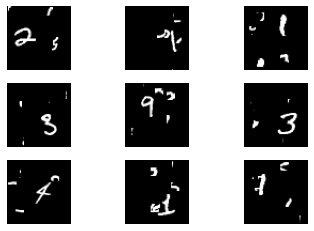

In [17]:
plot_mnist_grid(x_train[20:30])


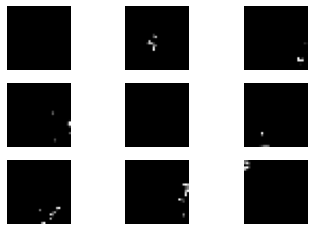

In [18]:
plot_mnist_grid(result[0])


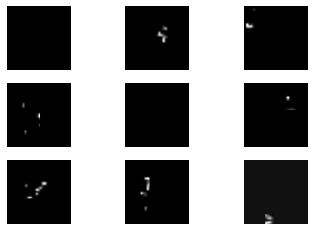

In [19]:
plot_mnist_grid(result[2])
